In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from astropy.io import fits
from astropy.table import Table


In [2]:
dat = Table.read(r'Test1.fits', format='fits')
df = dat.to_pandas()
n = 10
dataset = np.empty(n, dtype=object)
datasetX = np.empty(n, dtype=object)
datasetY = np.empty(n, dtype=object)

for i in range(n):
    dataset[i] = df.loc[np.array(range(df.shape[0])) % 100 == i, :]
for i in range(n):
    dataset[i].reset_index(drop=True,inplace=True)
    datasetX[i] = pd.DataFrame(StandardScaler().fit_transform(dataset[i][['ra','dec','dered_u','dered_g','dered_r','dered_i','dered_z']]),columns = ['ra','dec','dered_u','dered_g','dered_r','dered_i','dered_z'])
    datasetY[i] = dataset[i]['z']

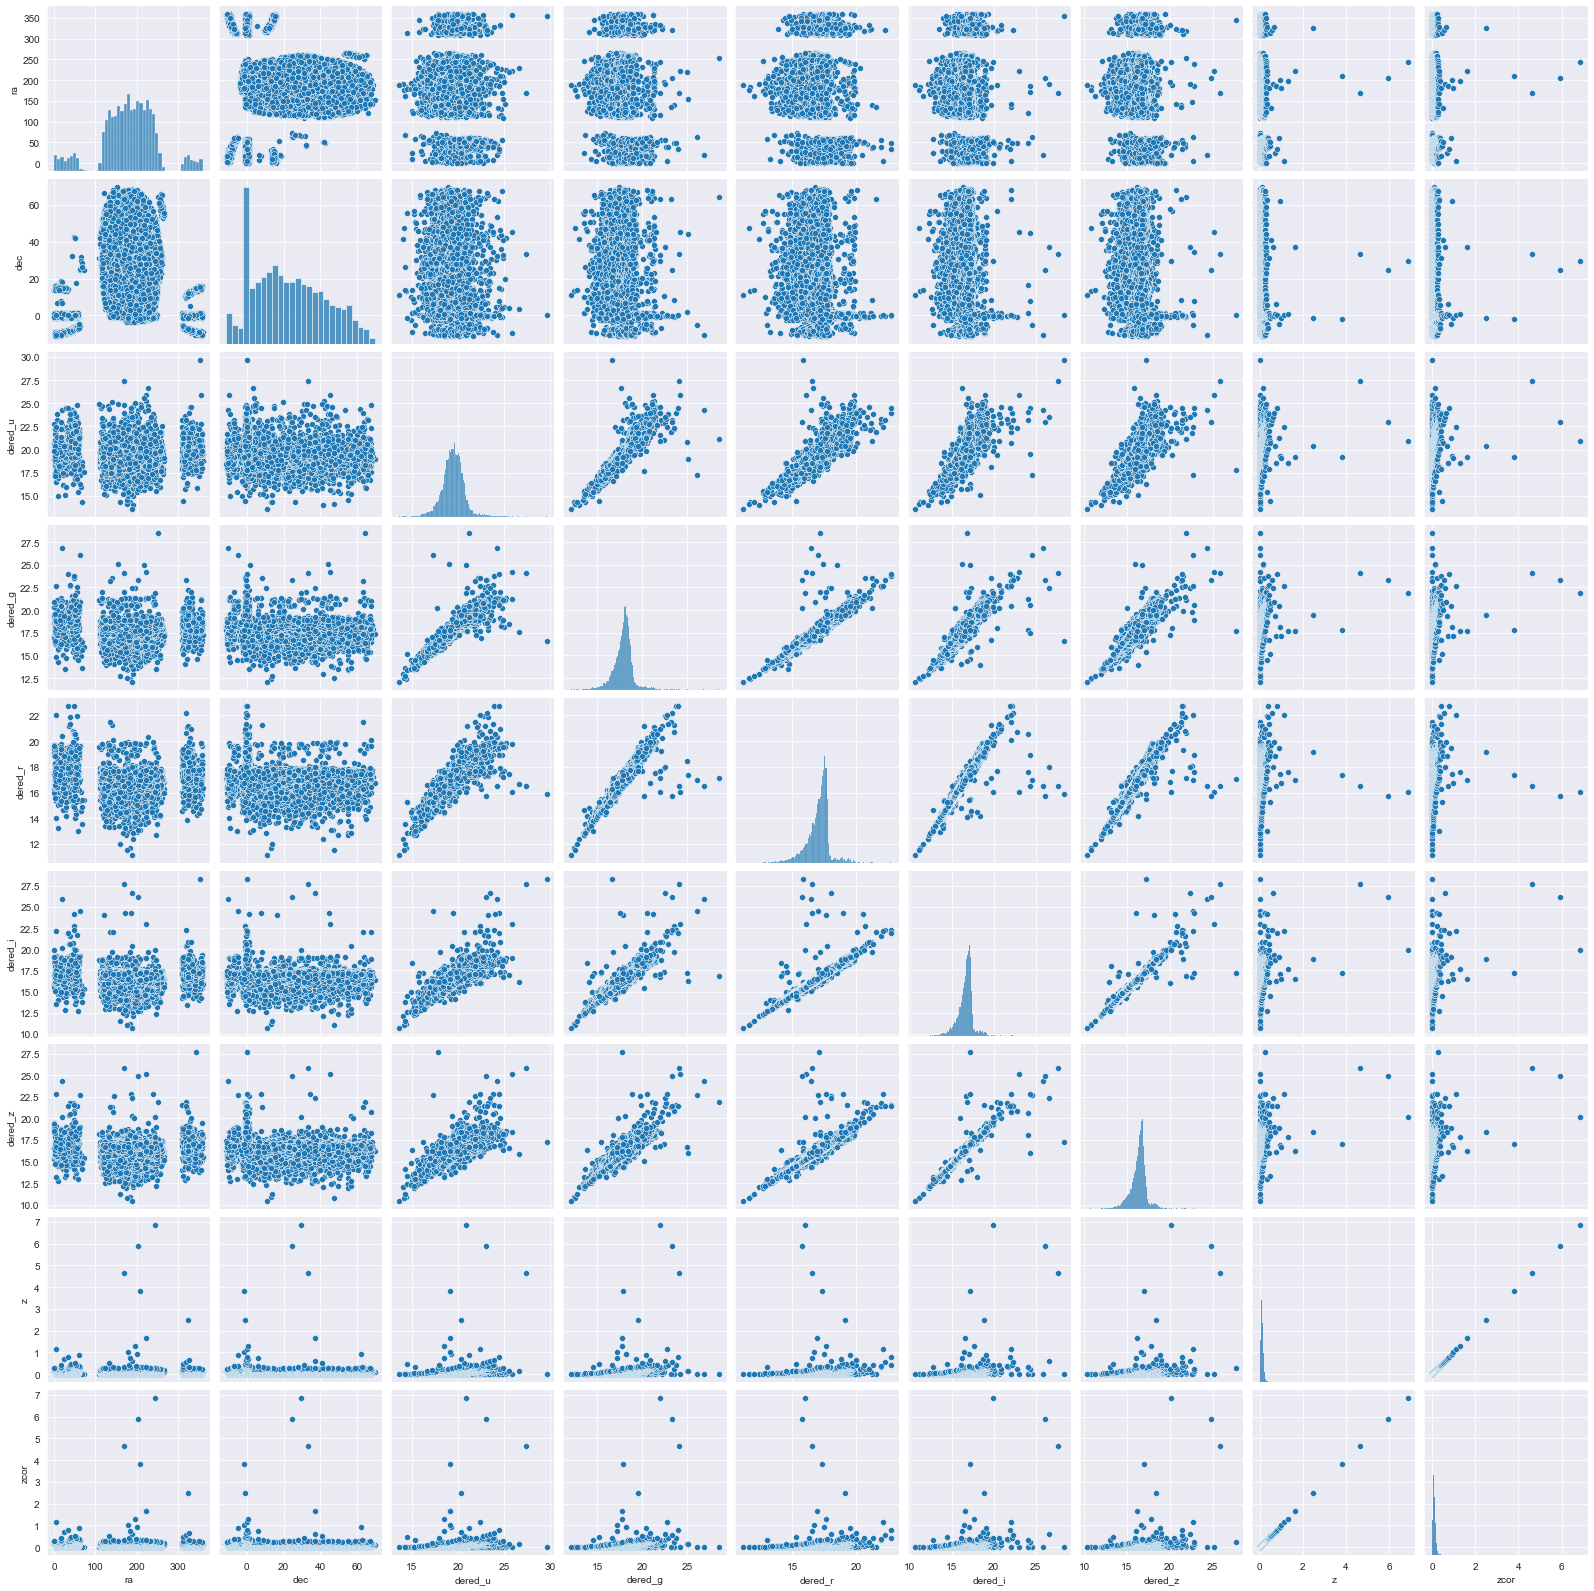

In [3]:
sns.pairplot(dataset[0])
plt.show()

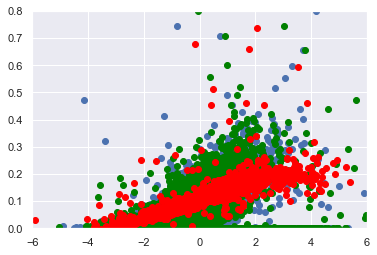

Fit score is  0.24718981724183842


In [4]:
linmod = LinearRegression()
linmod.fit(datasetX[0],datasetY[0])
yfit = linmod.predict(datasetX[2])
diffY = abs(datasetY[0] - yfit)

sns.set()
plt.scatter(datasetX[0]['dered_u'],datasetY[0])
plt.scatter(datasetX[3]['dered_u'],datasetY[3], color = 'green')
plt.scatter(datasetX[2]['dered_u'],yfit,color = 'red')
plt.xlim(-6,6)
plt.ylim(0,0.8)
plt.show()
print('Fit score is ', linmod.score(datasetX[0],datasetY[0]))


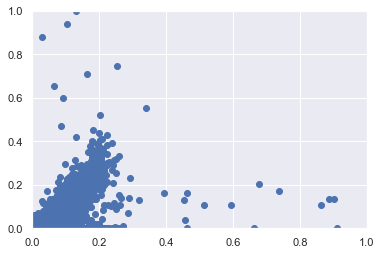

In [5]:
plt.scatter(yfit,datasetY[2])
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

In [6]:
mlp = MLPRegressor(hidden_layer_sizes=(7,100,100,100,1), activation='relu', solver='adam',batch_size='auto',random_state=33)
mlp.fit(datasetX[0],datasetY[0])
print('loss is ', mlp.loss_)
print('score is ', mlp.score(datasetX[0],datasetY[0]))

yprdct0 = mlp.predict(datasetX[8])
print(yprdct0[0:10])

sns.set()


loss is  0.0036737375492372896
score is  0.6911877839889302
[0.17087261 0.23498266 0.07924123 0.0399553  0.09448311 0.15253418
 0.09738287 0.09469313 0.06441988 0.08084367]


In [7]:
mlp.fit(datasetX[1],datasetY[1])
print('loss is ', mlp.loss_)
print('score is ', mlp.score(datasetX[1],datasetY[1]))

yprdct1 = mlp.predict(datasetX[8])
print(yprdct1[0:10])

loss is  0.006058768753345298
score is  0.37373974024137024
[0.18373041 1.42051441 0.11685897 0.0107985  0.95654076 0.95356628
 0.56697006 0.1843466  0.12787947 0.15470771]


In [8]:
mlp.fit(datasetX[2],datasetY[2])
print('loss is ', mlp.loss_)
print('score is ', mlp.score(datasetX[2],datasetY[2]))

yprdct2 = mlp.predict(datasetX[8])
print(yprdct2[0:10])

loss is  0.006453256927720864
score is  0.41814519268933215
[ 0.2280619   0.93255143  0.07056479 -0.08455073  0.24669743  0.29058052
  0.25434342  0.05301679  0.1322666   0.06538929]
